# VISUAL TRANSFORMERS

In [1]:
import os
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Normalization, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, F1Score, AUC
from tensorflow.keras.regularizers import L2
import sklearn

In [2]:
CONFIGURATION = {
    "CLASS_NAMES" : ['angry', 'happy', 'sad'],
    "BATCH_SIZE" : 32,
    "IMAGE_SIZE" : 256,
    "LEARNING_RATE" : 0.01,
    "N_EPOCHS" : 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 128,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 3,
    "PATCH_SIZE" : 16,
}

lossFunction = tf.keras.losses.CategoricalCrossentropy() # If Labels as One-Hot-Encodings
METRICS = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

trainDirectory = "/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/train"
testDirectory = "/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/test"

trainDataset = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)

valDataset = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='validation',
)

testDataset = tf.keras.utils.image_dataset_from_directory(
    testDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=None,
    subset=None,
)

trainDataset = trainDataset.prefetch(tf.data.AUTOTUNE)
testDataset = testDataset.prefetch(tf.data.AUTOTUNE)
valDataset = valDataset.prefetch(tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.
Using 5440 files for training.


2025-02-01 13:54:31.141261: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-01 13:54:31.141292: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-01 13:54:31.141297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-01 13:54:31.141316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-01 13:54:31.141327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 6799 files belonging to 3 classes.
Using 1359 files for validation.
Found 2278 files belonging to 3 classes.


## Testing Patch Extraction

In [3]:
testImage = cv2.imread("/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/test/happy/2705.jpg_rotation_1.jpg")
testImage = cv2.resize(testImage, (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]))

patches = tf.image.extract_patches(images=tf.expand_dims(testImage, axis=0),
                                   sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                                   strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')
patches.shape # -> 16*16*3 = 768 Patches

TensorShape([1, 16, 16, 768])

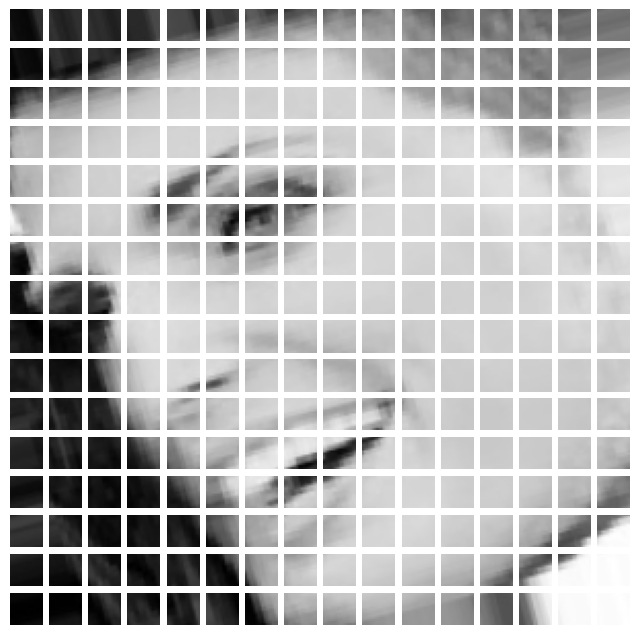

In [4]:
plt.figure(figsize=(8, 8))
k=0
for i in range(0, 16):
    for j in range(0, 16):
        plt.subplot(16, 16, k+1)
        plt.imshow(tf.reshape(patches[0, i, j, :], (CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 3)))
        plt.axis('off')
        k+=1

In [5]:
# Reshaping Patches To A Sequence
patches = tf.reshape(patches, (patches.shape[0], 256, 768))
patches.shape

TensorShape([1, 256, 768])

## Patch Encoder Layer

In [37]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim) 
    def call(self, x):
        patches = tf.image.extract_patches(images=x,
                                   sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                                   strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')
        
        patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

        batch_size = tf.shape(patches)[0]
        num_patches = tf.shape(patches)[1]
        positions = tf.range(start=0, limit=num_patches, delta=1)

        encoded = self.linear_projection(patches) + self.position_embedding(positions)

        return encoded

In [38]:
patchEnc = PatchEncoder(num_patches=16*16, projection_dim=CONFIGURATION["PATCH_SIZE"]*CONFIGURATION["PATCH_SIZE"]*3)
patchEnc(tf.zeros((32, CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3)))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[ 0.0032833 ,  0.01234742,  0.0075133 , ..., -0.01284649,
          0.04534172,  0.04133216],
        [-0.02682922,  0.0180327 ,  0.00464975, ...,  0.00854481,
         -0.03290247, -0.04885203],
        [-0.04853287,  0.04220805,  0.0088819 , ..., -0.04320606,
         -0.04595011, -0.01830589],
        ...,
        [ 0.00969913, -0.0272783 ,  0.04945779, ..., -0.03930805,
          0.0056054 , -0.04381749],
        [ 0.00018028,  0.01426775,  0.02216855, ...,  0.00806741,
          0.02162058, -0.02162814],
        [-0.01021506,  0.00542934, -0.01677626, ...,  0.03314045,
         -0.03299674,  0.02512905]],

       [[ 0.0032833 ,  0.01234742,  0.0075133 , ..., -0.01284649,
          0.04534172,  0.04133216],
        [-0.02682922,  0.0180327 ,  0.00464975, ...,  0.00854481,
         -0.03290247, -0.04885203],
        [-0.04853287,  0.04220805,  0.0088819 , ..., -0.04320606,
         -0.04595011, -0.01830589],
        ...

## Transformer Encoder Layer

In [39]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        
        self.multihead_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)

        self.dense1 = tf.keras.layers.Dense(units=projection_dim, activation=tf.nn.gelu)
        self.dense2 = tf.keras.layers.Dense(units=projection_dim, activation=tf.nn.gelu)

    def call(self, inputs):
        x = self.layernorm1(inputs)
        attn_output = self.multihead_attention(x, x)

        x = inputs + attn_output

        xNorm = self.layernorm2(x)
        xNorm = self.dense1(xNorm)
        xNorm = self.dense2(xNorm)

        output = x + xNorm

        return output

In [40]:
transformerEnc = TransformerEncoder(projection_dim=CONFIGURATION["PATCH_SIZE"]*CONFIGURATION["PATCH_SIZE"]*3, num_heads=4)
transformerEnc(tf.zeros((32, 16*16, CONFIGURATION["PATCH_SIZE"]*CONFIGURATION["PATCH_SIZE"]*3)))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0.

## Visual Transformer Model

In [41]:
class Vit(tf.keras.models.Model):
    def __init__(self, num_patches, projection_dim, transformer_layers, num_heads):
        super(Vit, self).__init__(name='vit')
        self.patch_encoder = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)
        self.transformer_encoders = [TransformerEncoder(projection_dim=projection_dim, num_heads=num_heads) for _ in range(transformer_layers)]
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=CONFIGURATION["N_DENSE_1"], activation=tf.nn.gelu)
        self.dropout1 = tf.keras.layers.Dropout(CONFIGURATION["DROPOUT_RATE"])
        self.dense2 = tf.keras.layers.Dense(units=CONFIGURATION["N_DENSE_2"], activation=tf.nn.gelu)
        self.dropout2 = tf.keras.layers.Dropout(CONFIGURATION["DROPOUT_RATE"])
        self.dense3 = tf.keras.layers.Dense(units=CONFIGURATION['NUM_CLASSES'], activation='softmax')
    def call(self, inputs):
        x = self.patch_encoder(inputs)

        for transformer in self.transformer_encoders:
            x = transformer(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)

        output = self.dense3(x)
        
        return output

In [42]:
vit = Vit(num_patches=16*16, projection_dim=CONFIGURATION["PATCH_SIZE"]*CONFIGURATION["PATCH_SIZE"]*3, transformer_layers=2, num_heads=4)
vit(tf.zeros((32, CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3)))
vit.summary()

Model: "vit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)    │ ?                      │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 196608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (32, 128)              │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,232,899 (180.18 MB)

 Trainable params: 47,232,899 (180.18 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=lossFunction,
    metrics=METRICS
)

## Transformer Training

In [44]:
history = vit.fit(trainDataset,
                  validation_data = valDataset, 
                  epochs=CONFIGURATION["N_EPOCHS"],
                  verbose=1)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3805 - loss: 336571.3125 - top_k_accuracy: 0.9058 - val_accuracy: 0.4459 - val_loss: 1.0595 - val_top_k_accuracy: 0.7800
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.4494 - loss: 1.0628 - top_k_accuracy: 0.7729 - val_accuracy: 0.4459 - val_loss: 1.0602 - val_top_k_accuracy: 0.7800
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.4456 - loss: 1.0638 - top_k_accuracy: 0.7714 - val_accuracy: 0.4459 - val_loss: 1.0601 - val_top_k_accuracy: 0.7800
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.4415 - loss: 1.0651 - top_k_accuracy: 0.7714 - val_accuracy: 0.4459 - val_loss: 1.0595 - val_top_k_accuracy: 0.7800
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.4433 - loss: 1.0640 - top_k_accuracy: 0.7749 - val_accuracy: 0.4459 - val_loss: 1.0600 - val_top_k_accuracy: 0.7800
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.4452 - loss: 

## RESULTS OF THE TRANSFORMER MODEL ARE NOT SO GOOD BECAUSE TO OBTAIN GOOD RESULTS WITH TRANSFORMERS, YOU NEED A VERY LARGE DATASET